# Solutions

1. Assuming the Nano-VNA is calibrated (2-port calibration) with center of 20 MHz and span of 1 kHz, aptures live data from Nano-VNA.
2. Calculate the 3dB bandwidth, Quality factors  ($Q_{0}$ and $Q_{L}$), and coupling factor.

## Analysis

In [1]:
import os
import sys
import numpy as np
from matplotlib import pyplot as plt
import skrf as rf
from math import pi, exp
from scipy.optimize import least_squares
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['font.size'] = 10
import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset'] = False
from nanovna import NanoVNA

In [2]:
class CrystalAnalysis:
    def __init__(self, co_fname=None):
        nv = NanoVNA()
        # make sure the calibrated stop and start frequencies are same for capturing data
        start_f, stop_f = 19.997600e6, 19.998600e6
        nv.set_sweep(start_f, stop_f)
        f = nv.fetch_frequencies()
        self. freq_data = (np.array(f))/1e6  # frequency in MHz
        self.s21 = nv.data(1)
        self.s11 = nv.data(0)

        self.s21_data = 20 * np.log10(np.abs(self.s21))  # magnitude in dB
        self.s21_deg = np.angle(self.s21)  # phase in radians
        self.s11_data = np.abs(self.s11)  # absolute values
        self.s11_deg = np.angle(self.s11)  # phase in radians
        # Results
        self.fs  = 0.0
        self.df  = 0.0
        self.Q_L = 0.0
        self.Q_0 = 0.0
        self.beta = 0.0
        self.Cm  = 0.0
        self.Lm  = 0.0
        # smith plot here, can clearly see under/critical/over coupling case
        self.s11_ant(nv)
        self.__call__()

    def beta_cal(self):
        s11_min = np.min(self.s11_data)
        ix = np.where(self.s11_data == s11_min)[0][0]
        if self.s11[ix].real < 0:
            s11_min = -s11_min
            print("############ Over-coupled #############")
        else:
            print("############ Under-coupled #############")
        self.beta = (1 - s11_min) / (1 + s11_min)

    def s11_ant(self, nv):
        self.beta_cal()
        fig, ax = plt.subplots()
        n = nv.skrf_network(self.s11)
        n.plot_s_smith()
        plt.title("Smith Chart")
        # text = "beta:{:.5f}".format(self.beta)
        # ax.text(self.beta, 0, text, va='top')

    def Rs_calc(self, s21, R_L):
        """ ESR calculation """
        Rs = 2 * R_L * (pow(10, (-s21 / 20)) - 1)
        Reff = 2 * R_L + Rs
        return Rs, Reff
    
    def df_calc(self, fl, fh):
        """ bandwidth calculation """
        return fh - fl
    
    def Cm_Lm_calc(self, fs, df, Rs, Reff):
        """ Calculate motional capacitance and inductance """
        Cm = df / (2.0 * pi * (pow(fs, 2)) * Reff)
        Lm = Reff / (2.0 * pi * df)
        Q_L = fs / df
        Q_0 = (1 + self.beta) * Q_L
        return Cm, Lm, Q_0, Q_L

    def find_max_freq_mag(self, data):
        """ find the maximum S21 magnitude and it's corresponding frequency """
        max_idx = np.where(data == np.amax(data))
        mag = np.max(data)
        freq = self.freq_data[max_idx][0]
        return (freq, mag)
    
    def find_nearest(self, array, value):
        """ find the value closest to the given data """
        idx = (np.abs(array - value)).argmin()
        return array[idx]

    def annot(self, ax, freq, mag, y, offset=0.1):
        """ used for annotating max, -3 dB points on S21 plot   """
        text= "{:.3f} dBm\n{:.5f} MHz".format(mag, freq)
        plt.axvline(x=freq, color = 'b', label = 'axvline - full height')
        ax.text(freq+offset, y,text, rotation=0, va='top')
    
    def ann_stats(self, ax, xloc, yloc):
        """ used for annotating crystal parameters on the S21 plot """
        txt  = "Cm: {:8.3f} pF\n".format(self.Cm/1e-15)
        txt += "Rs:  {:8.3f} Ohm\n".format(self.Rs)
        txt += "Lm: {:8.3f} mH\n".format(self.Lm/1e-3)
        txt += "bw: {:8.3f} Hz\n".format(self.df)
        txt += "Q_0:  {:8.3f}\n".format(self.Q_0)
        txt += "Q_L:  {:8.3f}\n".format(self.Q_L)
        txt += "Beta:  {:.5f}".format(self.beta)
        ax.text(xloc, yloc, txt, va='top')
    
    def find_3dB_points(self):
        """ find the -3 dB points """
        fs, mag   = self.find_max_freq_mag(self.s21_data)
        center_idx = np.where(self.s21_data == mag)[0][0]
        
        left_mag = self.find_nearest(self.s21_data[:center_idx], mag-3)
        left_idx = np.where(self.s21_data == left_mag)[0][0]
        left_freq = self.freq_data[left_idx]
        
        right_mag = self.find_nearest(self.s21_data[center_idx:], mag-3)
        right_idx = np.where(self.s21_data == right_mag)[0][0]
        right_freq = self.freq_data[right_idx]
        return ((left_freq, left_mag), (right_freq, right_mag))
    
    def plot_3db(self, fname):
        """ S21 magnitude plot """
        fig, ax = plt.subplots()
        plt.plot(self.freq_data, self.s21_data, "-b")
        self.annot(ax, self.freq_0deg, self.S21_0deg, np.max(self.s21_data), offset=0.00007)
        #self.annot(ax, self.freq_460MHz, self.S21_460MHz, np.max(self.s21_data)+0.7)
        idx = np.where(self.s21_data == self.left[1])
        self.annot(ax, self.left[0], self.left[1], self.s21_data[idx][0], offset=-0.0002)
        idx = np.where(self.s21_data == self.right[1])
        self.annot(ax, self.right[0], self.right[1], self.s21_data[idx][0], offset=0.00005)
        plt.title("S21")
        self.ann_stats(ax, plt.xlim()[0]+0.00002, plt.ylim()[1]-0.1)
        plt.grid(True)
        plt.xlabel("Frequency [MHz]")
        plt.ylabel("Magnitude [dBm]")
        #plt.show()   
        plt.savefig(fname)

    def __call__(self):
        self.freq_0deg, self.S21_0deg = self.find_max_freq_mag(self.s21_data)
        self.fs = self.freq_0deg

        self.left, self.right = self.find_3dB_points()
        self.Rs, self.Reff = self.Rs_calc(self.S21_0deg, 50)
        self.df = self.df_calc(self.left[0]*1e6, self.right[0]*1e6)
        self.Cm, self.Lm, self.Q_0, self.Q_L = self.Cm_Lm_calc(
            self.freq_0deg * 1e6, self.df, self.Rs, self.Reff)
        print("Resonance Freq: %3.4f MHz at %3.4f dBm" %(self.freq_0deg, self.S21_0deg))
        print("Full bandwidth: %3.4f Hz" %self.df)
        print("Q_L: %3.4f" %self.Q_L)
        print("Q_0: %3.4f" %self.Q_0)
        print("Coupling factor (beta): %.4f" %self.beta)

firmware version: 1.1.1
############ Under-coupled #############
Resonance Freq: 19.9981 MHz at -2.8911 dBm
Full bandwidth: 580.0000 Hz
Q_L: 34479.4828
Q_0: 53247.5749
Coupling factor (beta): 0.5443


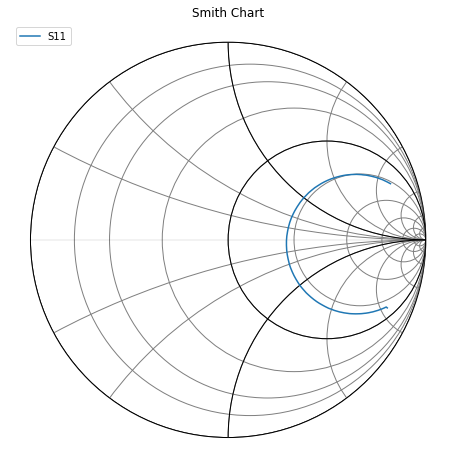

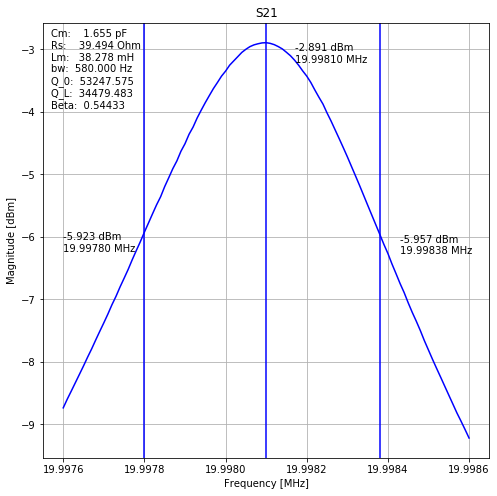

In [3]:
c = CrystalAnalysis()
c.plot_3db("Res_bw.png")
guess = (c.fs, c.Q_L)

# Expected crystal measurement results

| Crystal | fs (MHz) | max(S_21) (dB)     |  BW (Hz) |   Q_L   |   Q_0     |  Beta |
|:-------:|:--------:|:------------------:|:--------:|:-------:|:---------:|:-----:|
|       1 |   19.998 |             -11.87 |      310 | 64509.7 |  185670.7 | 1.878 |
|       2 |   19.998 |              -1.29 |      500 | 39996.1 |   68749.8 | 0.718 |
|       3 |   19.998 |              -3.42 |      630 | 31742.9 |   47512.4 | 0.496 |
|       4 |   19.998 |              -2.89 |      590 | 33894.9 |   52353.3 | 0.544 |
|       5 |   19.998 |             -12.07 |      320 | 62493.6 |  173206.2 | 1.771 |
|       6 |   19.998 |             -11.77 |      300 | 64509.7 | 190427.6  | 1.951 |
|       7 |   19.998 |              -3.05 |      420 | 47614.4 |   93406.3 | 0.961 |
|       8 |   19.998 |             -11.54 |      300 | 66660.1 |  204672.0 | 2.070 |
|       9 |   19.998 |              -2.87 |      580 | 34479.5 |   53230.0 | 0.544 |
